In [1]:
import tensorflow as tf
import numpy as np

2023-11-21 23:47:08.094029: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-21 23:47:08.094099: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-21 23:47:08.094118: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-21 23:47:08.101368: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
NUM_CLASSES = 100
WIDTH = 32
NUM_CHANNELS = 3
NUM_TRAIN = 50000
NUM_TEST = 10000
NUM_DEV = 100

DATASET = "cifar100"
BASE_DIR = ""  # set to whatever directory you are working/saving in
BATCH_SIZE = 512  # increase batch_size for faster training (if your file does not crash)

## Data loading

In [5]:
def _normalize(X):
  assert X.dtype == np.uint8
  X = X.astype(np.float64)
  X /= 255
  return X

def get_one_hot(targets, nb_classes):
  res = np.eye(nb_classes)[np.array(targets).reshape(-1)]
  return res.reshape(list(targets.shape)+[nb_classes])

def load_standard_cifar100():
  (X_train, Y_train), (X_validation, Y_validation) = tf.keras.datasets.cifar100.load_data()
  X_train = X_train.reshape(X_train.shape[0], WIDTH, WIDTH, NUM_CHANNELS)
  X_validation = X_validation.reshape(X_validation.shape[0], WIDTH, WIDTH, NUM_CHANNELS)

  X_train = _normalize(X_train)
  X_validation = _normalize(X_validation)

  Y_train = Y_train.astype(np.int32)
  Y_validation = Y_validation.astype(np.int32)

  return X_train, Y_train, X_validation, Y_validation

def load_cifar100_train_dev(num_dev=100, selected_dev=None):
  # randomly select and fixed for future (tracin-like strategy but their indices available only for mnist)
  # selected_dev = np.random.randint(0, X_validation.shape[0], num_dev)
  selected_dev = [5214, 2304, 5947, 9428, 2717, 8296, 7736, 8291, 5235, 54,
                  7499, 9590, 3675, 1932, 6646, 8719, 6484, 6306, 3066, 2442,
                  6106, 1949, 4320,  541, 1318, 5967, 2773, 3847, 1152, 9937,
                  7469, 5982, 7644, 5820, 8152, 9518,  601, 3953, 4931, 1924,
                  5342, 5467, 6718, 6779, 2860, 2440, 5480, 1178,  222, 7909,
                  6394, 3511, 8729, 6261, 7192, 9453, 5257, 9077, 6419, 3280,
                  3725, 3601, 8174, 5703, 4954, 9536, 4783, 2234, 7365, 2405,
                  3073, 2780, 7461, 3525, 7573, 6764, 9962, 7527,  992,  315,
                  6260, 9061,  592, 8003, 7594, 1930, 7215, 5124, 7531, 9471,
                  2824, 3533, 6062, 3946, 5246, 4440,  414, 3572, 4899, 884]
  X_train, Y_train, X_validation, Y_validation = load_standard_cifar100()
  X_dev = X_validation[selected_dev]
  Y_dev = Y_validation[selected_dev]
  return X_train, Y_train, X_dev, Y_dev

In [6]:
# X_train, Y_train, X_dev, Y_dev = load_cifar10_train_dev()

# conduct exploration based on memorization
# select dev set based on memorization scores
# first 25 high-mem (>0.9), next 25 med-mem (0.4-0.6) and last 50 low-mem (<0.1) instances
selected_dev = [ 1075, 34033,  5493, 40363, 30042,  5626, 41505, 37982,  7970, 6576, 25030, 39984,   535, 12051, 25953, 36214, 36037, 20184, 36003, 24186, 25619, 48576, 38498, 36517, 30093, 49770,  5601, 7162, 42005, 29670, 29525,  7144,  2103, 32021, 21286,  9826, 13950, 31891, 33396, 11636, 33512, 16989, 46732,  8562, 24911, 22121,  7299, 37157, 41412, 26147, 39450, 28933,  4457, 39655, 20024,   914, 14761, 14404,  5321,  8839, 29797, 15728, 42305, 28441, 32679,   963, 16498, 25505, 43944, 46180, 12346, 14728, 4344, 24199, 18249, 26364, 47172, 22227, 38149, 34972, 30768, 33000, 43948,  5161, 10436, 41042, 39750, 45714, 26910, 11997, 8599, 11824, 19886, 17737, 37730,  1417,  6623, 33458, 38684, 39262]
X_train, Y_train, X_test, Y_test = load_standard_cifar100()
X_dev, Y_dev = X_train[selected_dev], Y_train[selected_dev]

In [7]:
Y_train = np.squeeze(np.array(Y_train))
Y_test = np.squeeze(np.array(Y_test))
Y_dev = np.squeeze(np.array(Y_dev))

In [8]:
print(X_train.shape, X_test.shape, X_dev.shape, Y_train.shape, Y_test.shape, Y_dev.shape)

(50000, 32, 32, 3) (10000, 32, 32, 3) (100, 32, 32, 3) (50000,) (10000,) (100,)


### Data Poisoning

In [9]:
pct_poison = 1
num_poison = int((pct_poison/100) * len(Y_train))
ix_poison = np.random.choice(len(Y_train), num_poison, replace=False)

In [10]:
Y_train_dp = Y_train.copy()

for i in ix_poison:
    y_curr = Y_train[i]
    y_new = np.random.choice([y for y in range(NUM_CLASSES) if y != y_curr])
    Y_train_dp[i] = y_new

ix_poisoned = np.zeros(len(Y_train)).astype(int)
ix_poisoned[ix_poison] = 1

In [11]:
# np.save(f"{BASE_DIR}/{DATASET}_Y_train_dp_{pct_poison}pct.npy", Y_train_dp)
# np.save(f"{BASE_DIR}/{DATASET}_ix_poisoned_{pct_poison}pct.npy", ix_poisoned)

## Model training

In [12]:
def dnn_custom(inp_dim, out_dim, dnn='resnet50', train_full=False, weights='imagenet', dropout_pct=0.25, use_upsampling=False):
    inp_dim_orig = inp_dim
    if use_upsampling:
      inp_dim = (224,224,3)
    if dnn=='resnet50':
      dnn_model = tf.keras.applications.ResNet50(weights=weights, include_top=False, input_shape=inp_dim)
    elif dnn=='mobilenet':
      dnn_model = tf.keras.applications.MobileNet(weights=weights, include_top=False, input_shape=inp_dim)
    elif dnn=='mobilenetv3':
      dnn_model = tf.keras.applications.MobileNetV3Small(weights=weights, include_top=False, input_shape=inp_dim)
    elif dnn=='efficientnetb0':
      dnn_model = tf.keras.applications.EfficientNetB0(weights=weights, include_top=False, input_shape=inp_dim)
    elif dnn=='efficientnetb3':
      dnn_model = tf.keras.applications.EfficientNetB3(weights=weights, include_top=False, input_shape=inp_dim)

    if not train_full:
      for layer in dnn_model.layers:
          if isinstance(layer, tf.keras.layers.BatchNormalization):
              layer.trainable = True
          else:
              layer.trainable = False

    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Input(shape=inp_dim_orig))
    if use_upsampling & inp_dim_orig[0] != 224:
      model.add(tf.keras.layers.UpSampling2D(size=(224/inp_dim_orig[0], 224/inp_dim_orig[0]), interpolation='bilinear'))
    model.add(dnn_model)
    model.add(tf.keras.layers.GlobalAveragePooling2D())
    model.add(tf.keras.layers.Dropout(dropout_pct))
    model.add(tf.keras.layers.Dense(out_dim*16, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(out_dim, activation='softmax'))
    return model

In [13]:
# # not using when upsampling since ~0.75 accuracy without it
# train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
#         rotation_range = 10,
#         zoom_range = 0.1,
#         width_shift_range = 0.1,
#         height_shift_range = 0.1,
#         shear_range = 0.1,
#         horizontal_flip = True,
#         vertical_flip = False
#         )
# train_datagen.fit(X_train)

In [14]:
pct_poison = 1
# Y_train is the poisoned data (to require minimal changes in pipeline ahead)
Y_train = np.load(f"{BASE_DIR}/{DATASET}_Y_train_dp_{pct_poison}pct.npy")
ix_poisoned = np.load(f"{BASE_DIR}/{DATASET}_ix_poisoned_{pct_poison}pct.npy")

In [ ]:
BASE_DNN = 'resnet50'  # 'efficientnetb0'
EPOCHS = 1000
saved_epochs = [100, 200, 237, 300, 400, 500, 600, 700, 750, 900, 1000]

start_epoch = 0
for e in saved_epochs:
    try:
        clf = tf.keras.models.load_model(f"{BASE_DIR}/{DATASET}_{BASE_DNN}_{e}e_{pct_poison}dp.h5")
        start_epoch = e
    except:
        break
    
if start_epoch == 0:
    clf = dnn_custom(inp_dim=(32,32,3), out_dim=NUM_CLASSES, dnn=BASE_DNN, dropout_pct=0, train_full=False, use_upsampling=True)
    clf.compile(
        optimizer='Adam', 
        loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
        metrics=['accuracy', tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5)]
    )

print(start_epoch)
for i in range(start_epoch+1,EPOCHS+1):
  if (i%10) == 0:
    print(i)
  clf.fit(X_train, Y_train, epochs=1, batch_size=BATCH_SIZE, validation_data=(X_test, Y_test), verbose=1)
  if i in saved_epochs:
    clf.save(f"{BASE_DIR}/{DATASET}_{BASE_DNN}_{i}e_{pct_poison}dp.h5")

2023-11-20 19:48:54.808985: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78953 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:21:00.0, compute capability: 8.0


900


2023-11-20 19:49:20.076088: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8902
2023-11-20 19:49:27.121159: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x2b489401ae20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-20 19:49:27.121214: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2023-11-20 19:49:27.126434: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-20 19:49:27.343247: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


98/98 [==============================] - 53s 544ms/step - loss: 4.1895e-04 - accuracy: 0.9997 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 2.6023 - val_accuracy: 0.7375 - val_sparse_top_k_categorical_accuracy: 0.9235
910
35/98 [=========>....................] - ETA: 31s - loss: 2.3102e-04 - accuracy: 0.9998 - sparse_top_k_categorical_accuracy: 1.0000

## RPS

### Model Loading

In [69]:
pct_poison = 1
trained_epochs = 100
base_dnn = 'resnet50'

MODEL_DIR = f"{BASE_DIR}/{DATASET}_{base_dnn}_{trained_epochs}e_{pct_poison}dp.h5"
model = tf.keras.models.load_model(MODEL_DIR)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 up_sampling2d_1 (UpSamplin  (None, 224, 224, 3)       0         
 g2D)                                                            
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 1600)              3278400   
                                                                 
 batch_normalization_1 (Bat  (None, 1600)             

### Getting hidden outputs

In [70]:
features_input = tf.keras.Input(shape=(WIDTH, WIDTH, NUM_CHANNELS))
labels_input = tf.keras.Input(shape=(NUM_CLASSES,))

In [71]:
h_x = features_input
for layer_num in range(len(model.layers) - 2):
  h_x = model.layers[layer_num](h_x, training=False)
last_layer_model = tf.keras.Model(inputs=features_input, outputs=h_x)
last_layer_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 up_sampling2d_1 (UpSamplin  (None, 224, 224, 3)       0         
 g2D)                                                            
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 1600)              327840

In [72]:
X_hidden_outputs = last_layer_model.predict(X_train)
X_hidden_outputs.shape

1563/1563 [==============================] - 23s 14ms/step


(50000, 1600)

In [73]:
P_train = model.predict(X_train)
P_test = model.predict(X_test)

313/313 [==============================] - 5s 16ms/step


In [74]:
print(f"Accuracy (Train): {(P_train.argmax(axis=1) == np.squeeze(Y_train)).mean()}")
print(f"Accuracy (Test): {(P_test.argmax(axis=1) == np.squeeze(Y_test)).mean()}")

Accuracy (Train): 0.98978
Accuracy (Test): 0.7352


### Representer

In [75]:
import time

In [76]:
class Linear(tf.keras.Model):
  def __init__(self, num_classes):
    super(Linear, self).__init__()
    self.fc = tf.keras.layers.Dense(
        num_classes,
        kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01))

  def call(self, inputs):
    return self.fc(inputs)

def run():
  ###############################################
  start_time = int(time.time())

  num_train_examples = NUM_TRAIN
  tensorboard_summary_dir = (f"{BASE_DIR}/tmp/{DATASET}/original/representer/{start_time}/tensorboard/")
  checkpoint_dir = (f"{BASE_DIR}/tmp/{DATASET}/original/representer/{start_time}/checkpoint/")

  epochs = 100
  lr = 1.0
  num_classes = NUM_CLASSES
  ###################
  train_batch_size = 50000
  # train_batch_size = 60000
  # strategy_str = "one_gpu"
  # tpu_address = "v3-8"
  lam = 0.001
  checkpoint_frequency = 250
  ###############################################
  # strategy = get_strategy(strategy_str, tpu_address=tpu_address)
  # if train_batch_size % strategy.num_replicas_in_sync != 0:
  #   raise ValueError(
  #       'Train batch size must be divisible by number of replicas : {}'.format(
  #           strategy.num_replicas_in_sync))
  train_steps_per_epoch = num_train_examples // train_batch_size


  BATCH_SIZE = 200
  train_ds = tf.data.Dataset.from_tensor_slices((tf.cast(X_hidden_outputs, dtype=tf.float32), P_train)).take(num_train_examples).batch(BATCH_SIZE, drop_remainder=True)


  final_layer = Linear(num_classes)
  optim = tf.keras.optimizers.SGD(learning_rate=lr)

  train_loss = tf.keras.metrics.Mean('train_loss', dtype=tf.float32)
  train_accuracy = tf.keras.metrics.TopKCategoricalAccuracy(
      1, 'train_accuracy', dtype=tf.float32)
  grad_norm = tf.keras.metrics.Mean('grad_norm', dtype=tf.float32)

  final_layer_checkpoint = tf.train.Checkpoint(model=final_layer)

  train_iter = iter(train_ds)

  @tf.function
  def train_step(inputs):
    hidden_outputs, probs = inputs
    with tf.GradientTape() as tape:
      logits = final_layer(hidden_outputs)
      loss = tf.keras.losses.categorical_crossentropy(
          probs, logits, from_logits=True)
      loss = tf.reduce_mean(loss)

      l2_loss = lam * tf.add_n([
          tf.nn.l2_loss(v)
          for v in final_layer.trainable_weights])
      loss += l2_loss

    grads = tape.gradient(loss, final_layer.trainable_weights)
    g_norm = tf.norm(tf.concat([grads[0],
        tf.expand_dims(grads[1], axis=0)], axis=0))
    beta = tf.constant(0.5)
    t = tf.constant(10.0)

    while tf.constant(True):
      new_logits = tf.matmul(hidden_outputs, (final_layer.trainable_weights[0]-t*grads[0])) + (
          (final_layer.trainable_weights[1]-t*grads[1]))
      new_loss = tf.keras.losses.categorical_crossentropy(
          probs, new_logits, from_logits=True)
      new_loss = tf.reduce_mean(new_loss)
      new_l2_loss = lam * tf.add_n([
          tf.nn.l2_loss(v-t*g)
          for g, v in zip(grads, final_layer.trainable_weights)])
      new_loss += new_l2_loss
      if tf.less_equal(new_loss - loss + t * g_norm *  g_norm * 0.5, 0):
        break
      t *= beta
      if tf.less(t, 0.0000000001):
        t *= 0.0
        break
    optim.apply_gradients(zip([t * grad for grad in grads], final_layer.trainable_weights))


    train_loss.update_state(loss)
    grad_norm.update_state(g_norm)
    train_accuracy.update_state(probs, logits)

  for epoch in range(1, epochs + 1):
    train_loss.reset_states()
    train_accuracy.reset_states()
    grad_norm.reset_states()
    train_steps_in_current_epoch = 0
    for inputs in train_ds:
      train_step(inputs)
      steps = min(train_steps_per_epoch,
                  train_steps_per_epoch - train_steps_in_current_epoch)

      train_steps_in_current_epoch += steps

    print('Done training epoch %s' % (epoch))
    print('train_loss %f' % (train_loss.result()))
    print('train_accuracy %f' % (train_accuracy.result()))
    print('grad_norm %f' % (grad_norm.result()))

    # Save checkpoint
    if epoch % checkpoint_frequency == 0:
      checkpoint_name = final_layer_checkpoint.save(
          os.path.join(checkpoint_dir,
              'model-{epoch:04d}.ckpt'.format(epoch=epoch)))
      print('Saved checkpoint to %s', checkpoint_name)
    print('==================================================')

    current_steps = epoch * train_steps_per_epoch
  return final_layer

final_layer = run()

2023-11-22 00:06:32.374590: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x2b0fe4002520 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-22 00:06:32.375370: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2023-11-22 00:06:32.516604: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Done training epoch 1
train_loss 1.543797
train_accuracy 0.692360
grad_norm 4.459608
Done training epoch 2
train_loss 0.542916
train_accuracy 0.891300
grad_norm 2.767560
Done training epoch 3
train_loss 0.350784
train_accuracy 0.942080
grad_norm 2.045921
Done training epoch 4
train_loss 0.269268
train_accuracy 0.961460
grad_norm 1.712484
Done training epoch 5
train_loss 0.217167
train_accuracy 0.972640
grad_norm 1.457661
Done training epoch 6
train_loss 0.180694
train_accuracy 0.982060
grad_norm 1.234923
Done training epoch 7
train_loss 0.155097
train_accuracy 0.987440
grad_norm 1.049154
Done training epoch 8
train_loss 0.137071
train_accuracy 0.991640
grad_norm 0.894210
Done training epoch 9
train_loss 0.125590
train_accuracy 0.994580
grad_norm 0.782953
Done training epoch 10
train_loss 0.117869
train_accuracy 0.996160
grad_norm 0.701349
Done training epoch 11
train_loss 0.112164
train_accuracy 0.997200
grad_norm 0.632611
Done training epoch 12
train_loss 0.108348
train_accuracy 0.997

In [77]:
def get_one_hot(targets, nb_classes):
  res = np.eye(nb_classes)[np.array(targets).reshape(-1)]
  return res.reshape(list(targets.shape)+[nb_classes])

In [78]:
### want to work with entire test data as dev set for intersection effect
X_dev = X_test
Y_dev = Y_test

In [79]:
Y_dev_one_hot = get_one_hot(Y_dev, NUM_CLASSES)
Y_train_one_hot = get_one_hot(Y_train, NUM_CLASSES)

Y_train_one_hot = np.squeeze(Y_train_one_hot)
Y_dev_one_hot = np.squeeze(Y_dev_one_hot)

In [80]:
probs = tf.nn.softmax(final_layer(X_hidden_outputs))
weight_matrix = probs-Y_train_one_hot

X_dev_hidden_outputs = last_layer_model.predict(X_dev)

val_feature = X_dev_hidden_outputs
train_feature = X_hidden_outputs

val_feature_n = (val_feature.T / np.linalg.norm(val_feature, axis=1)).T
train_feature_n = (train_feature.T / np.linalg.norm(train_feature, axis=1)).T

alpha_js = []
representer_vals = []
sim_vals, sim_vals_normalized = [], []
for test_point in range(X_dev.shape[0]):
  target_class = np.squeeze(Y_dev[test_point])
  alpha_j = weight_matrix[:, target_class]
  sim_val = np.sum(train_feature * val_feature[test_point,:], axis=1)
  sim_val_normalized = np.sum(train_feature_n * val_feature_n[test_point,:], axis=1)
  representer_val = alpha_j * np.sum(train_feature * val_feature[test_point,:], axis=1)

  alpha_js.append(alpha_j)
  representer_vals.append(-1*representer_val)
  sim_vals.append(sim_val)
  sim_vals_normalized.append(sim_val_normalized)

np.save(f"{BASE_DIR}/{DATASET}_{base_dnn}_alpha_{trained_epochs}e_{pct_poison}dp.npy", weight_matrix, allow_pickle=True)
np.save(f"{BASE_DIR}/{DATASET}_{base_dnn}_alpha_j_{trained_epochs}e_{pct_poison}dp.npy", alpha_js, allow_pickle=True)
np.save(f"{BASE_DIR}/{DATASET}_{base_dnn}_representer_val_{trained_epochs}e_{pct_poison}dp.npy", representer_vals, allow_pickle=True)
np.save(f"{BASE_DIR}/{DATASET}_{base_dnn}_similarity_{trained_epochs}e_{pct_poison}dp.npy", sim_vals, allow_pickle=True)
np.save(f"{BASE_DIR}/{DATASET}_{base_dnn}_similarity_normalized_{trained_epochs}e_{pct_poison}dp.npy", sim_vals_normalized, allow_pickle=True)

313/313 [==============================] - 4s 14ms/step


## Analysis

In [81]:
pct_poison = 1
trained_epochs = 100
base_dnn = 'resnet50'

ix_poisonned = np.load(f"{BASE_DIR}/{DATASET}_ix_poisoned_{pct_poison}pct.npy", allow_pickle=True)
inf = np.load(f"{BASE_DIR}/{DATASET}_{base_dnn}_representer_val_{trained_epochs}e_{pct_poison}dp.npy", allow_pickle=True)

In [82]:
inf = -1*inf

In [88]:
n_top = 3

ix_top_list = []
for j in range(inf.shape[0]):
  inf_j = inf[j].copy()
  get_largest = False  # need get smallest perhaps because influence is -1*rep_val
  if get_largest:
    ix_top = np.argpartition(inf_j, -n_top)[-n_top:]
  else:
    ix_top = np.argpartition(inf_j, n_top-1)[:n_top]

  ix_top_list.append(ix_top)

ix_top_list = np.array(ix_top_list)

In [89]:
np.unique(Y_test, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99],
       dtype=int32),
 array([100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
        100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
        100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
        100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
        100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
        100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
        100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
        100, 100, 1

In [90]:
# thresh = 90
thresh = 100

val_counts = {v:c for v, c in zip(*np.unique(ix_top_list, return_counts=True)) if c>=thresh}
# print(len(val_counts))
# val_counts

In [91]:
# indices of poisoned data
poisonned = np.where(ix_poisonned == 1)[0]

print(f"{len([i for i in list(val_counts.keys()) if i in poisonned])} of {len(val_counts)} training images found repeatedly in top-{n_top} of {thresh}+ test images were from poisonned data.")
top_ix_not_poisonned = [i for i in list(val_counts.keys()) if i not in poisonned]

178 of 188 training images found repeatedly in top-3 of 100+ test images were from poisonned data.


In [45]:
poisonned = np.where(ix_poisonned == 1)[0]

In [46]:
P_train = model.predict(X_train)
P_train = P_train.argmax(axis=1)

1563/1563 [==============================] - 25s 16ms/step


In [47]:
mislabeled = np.where(Y_train != P_train)[0]

In [48]:
top_ix_poisonned = [i for i in list(val_counts.keys()) if i in poisonned]
top_ix_mislabeled = [i for i in list(val_counts.keys()) if i in mislabeled]
# the two above are not mutually exclusive (i.e., can have overlap)

In [50]:
print(f"{len(top_ix_poisonned)} of {len(val_counts)} training images found repeatedly in top-{n_top} of {thresh}+ test images were from poisonned data.")
print(f"{len(top_ix_mislabeled)} of {len(val_counts)} training images found repeatedly in top-{n_top} of {thresh}+ test images were from mislabeled data.")

19 of 61 training images found repeatedly in top-1 of 100+ test images were from poisonned data.
28 of 61 training images found repeatedly in top-1 of 100+ test images were from mislabeled data.


In [67]:
import matplotlib.pyplot as plt
str_labels = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm']
label_dict = {i: str_labels[i] for i in range(len(str_labels))}

1/1 [==============================] - 0s 17ms/step


/tmp/ipykernel_120185/2181943392.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


1/1 [==============================] - 0s 17ms/step


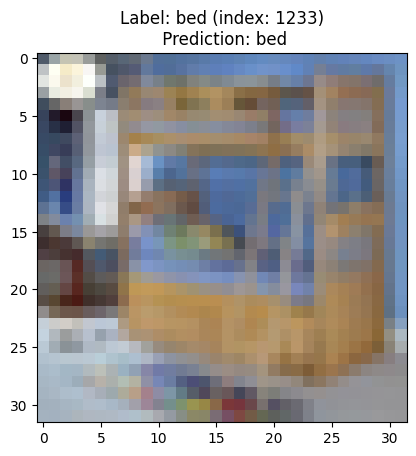

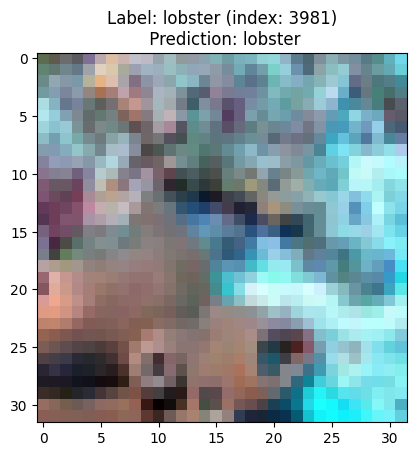

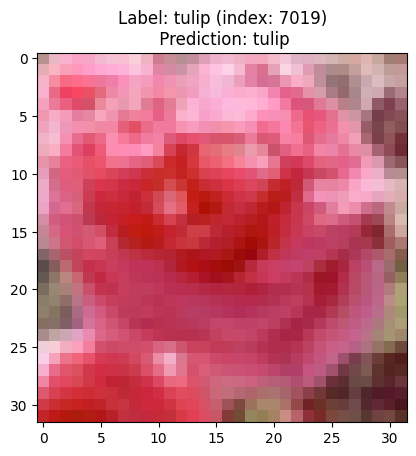

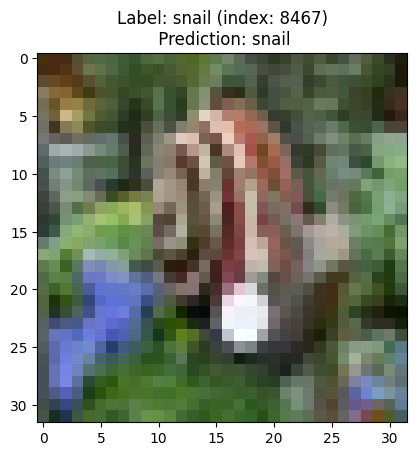

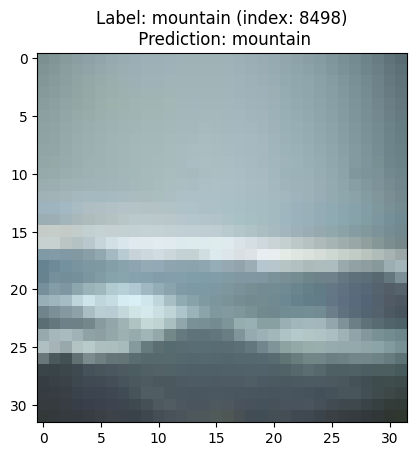

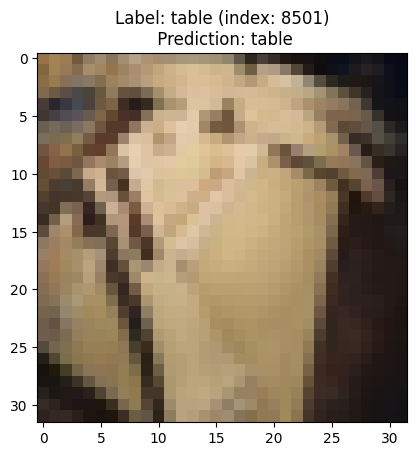

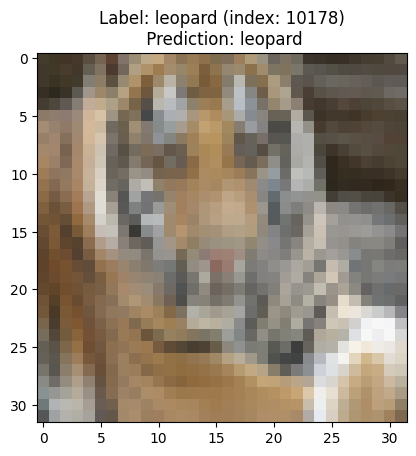

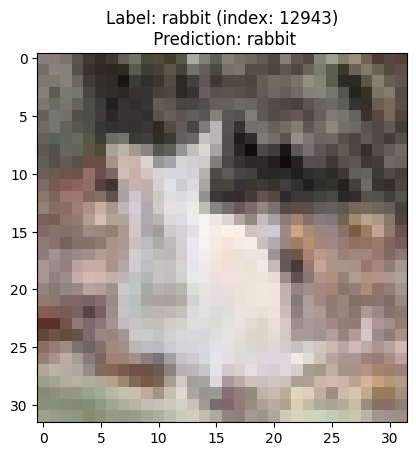

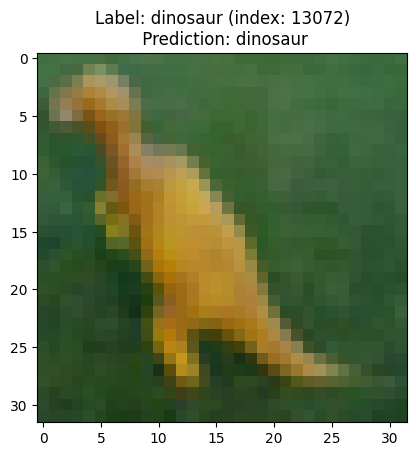

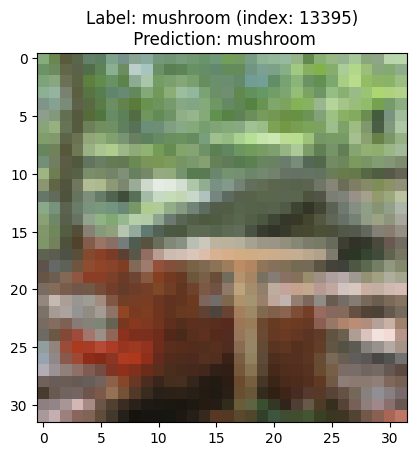

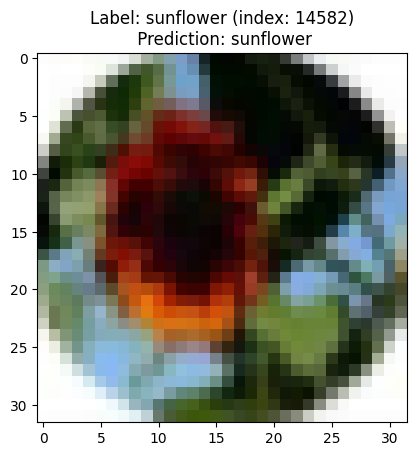

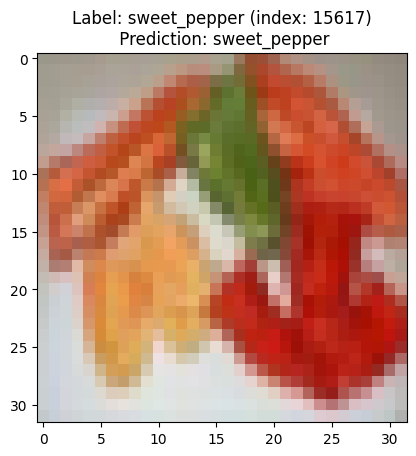

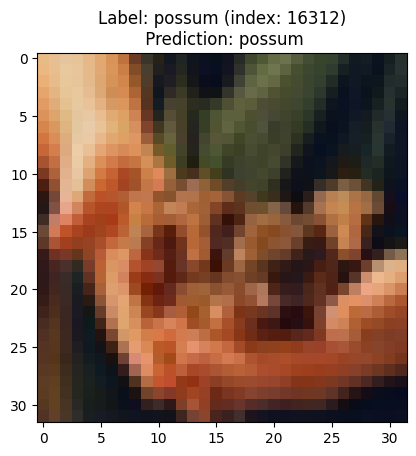

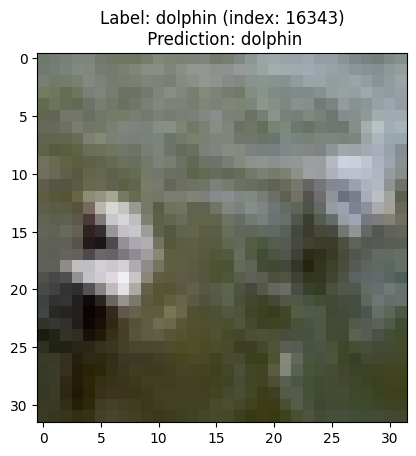

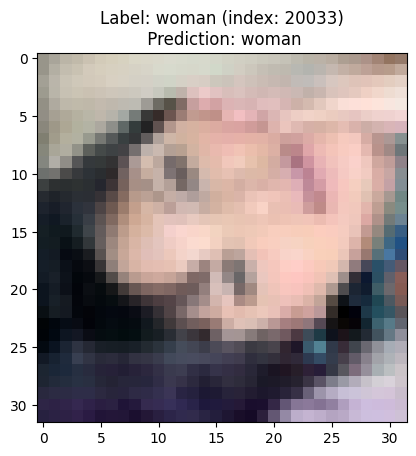

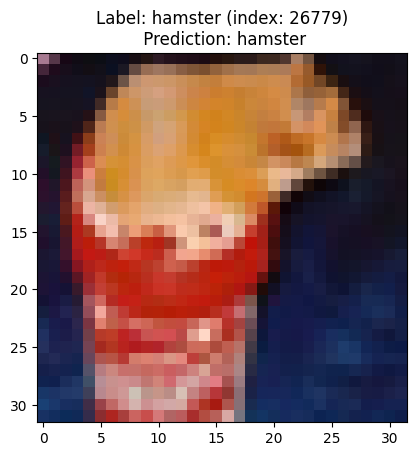

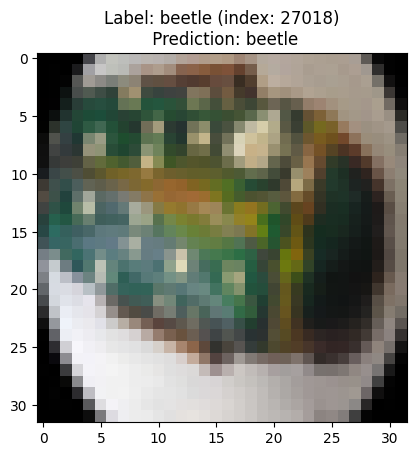

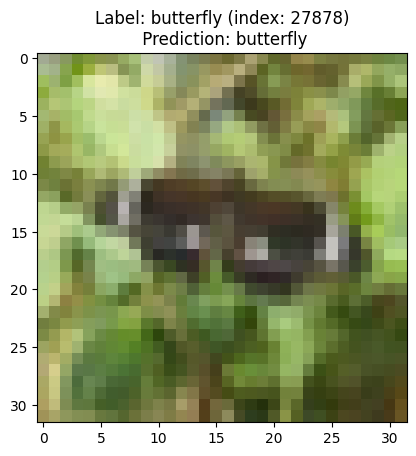

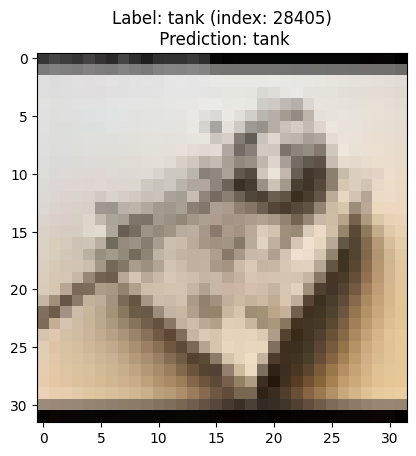

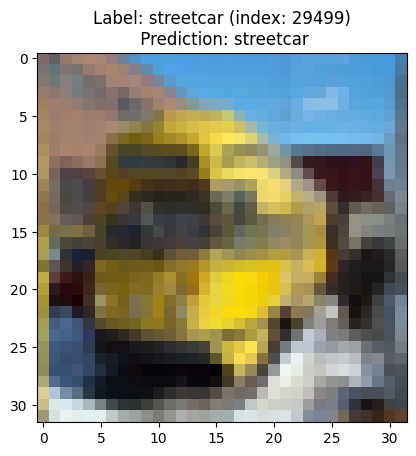

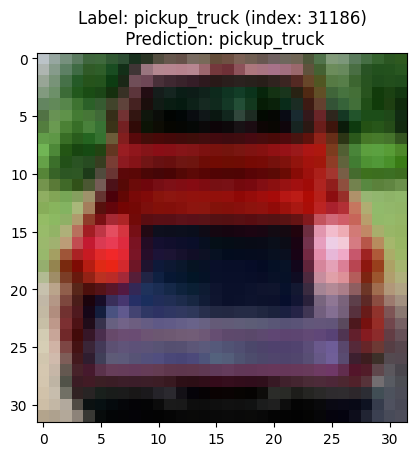

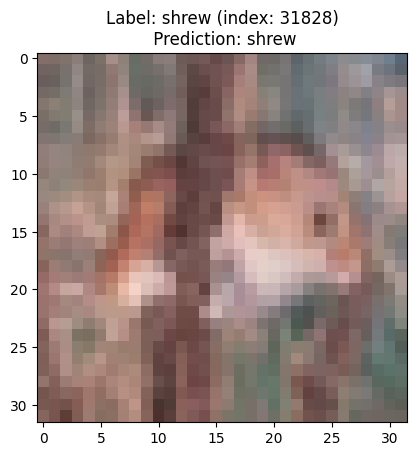

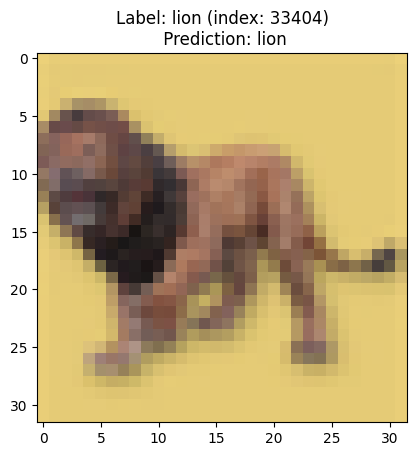

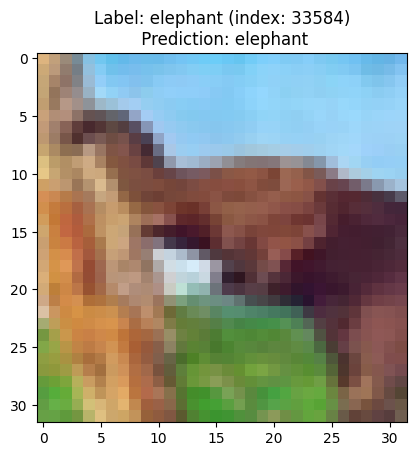

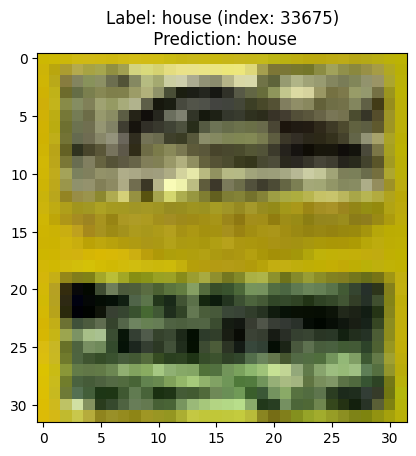

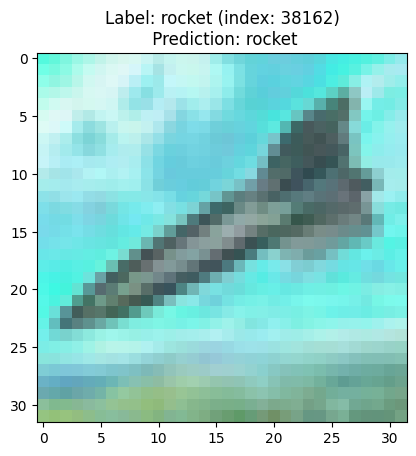

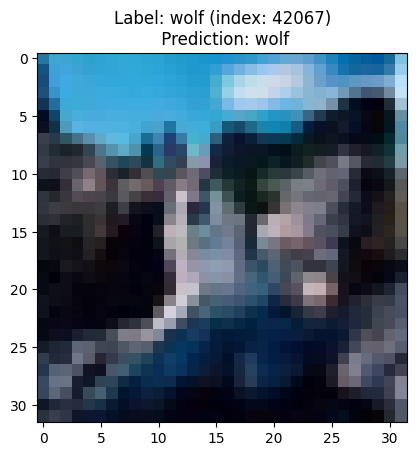

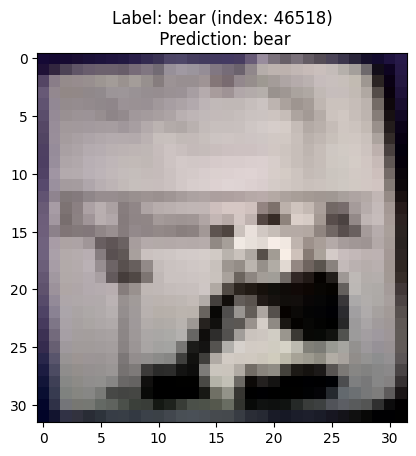

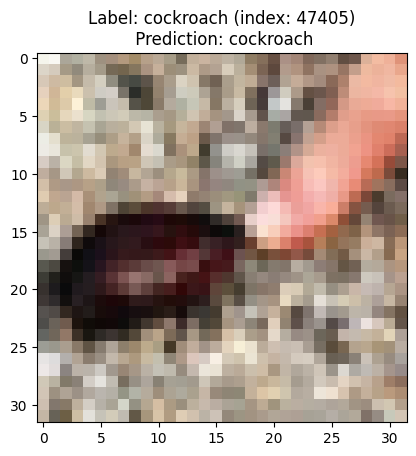

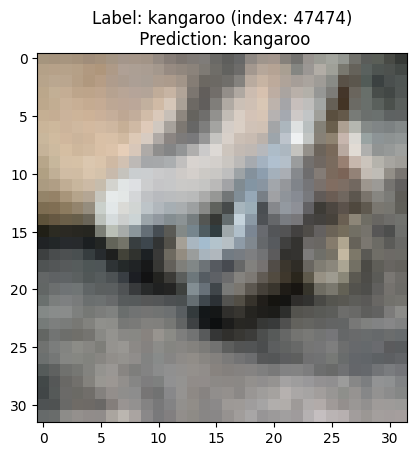

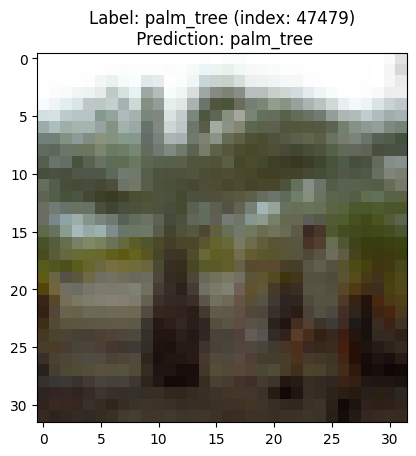

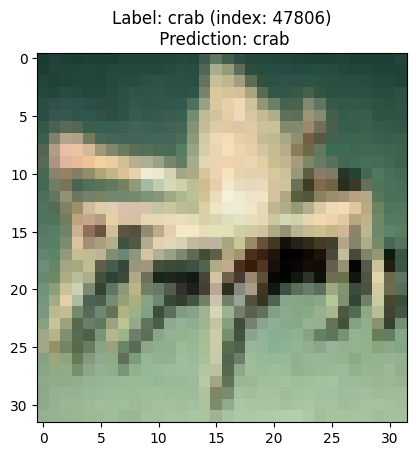

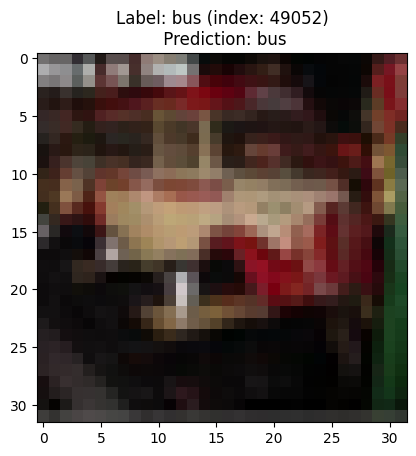

In [68]:
top_ix_not_mislabeled_or_poisoned = [i for i in list(val_counts.keys()) if (i not in mislabeled) and (i not in poisonned)]
for i in top_ix_not_mislabeled_or_poisoned:
    plt.figure()
    plt.imshow(X_train[i])
    plt.title(f"Label: {label_dict[Y_train[i]]} (index: {i})\n Prediction: {label_dict[np.argmax(model.predict(X_train[i][np.newaxis,:]))]}")

33

In [62]:
len()

33